# A Binary Tree Approach to Precompute EMCC for Efficient Causal Inference

This bundle contains the manuscript submited to the journal Kybernetika and entitled  "A Binary Tree Approach to Precompute EMCC for Efficient Causal Inference".
The organisation  is the following:

- _examples_: a toy example for running the method proposed in the paper.
- _models_: set of structural causal models considered in the experimentation.
- _requirements.txt_: code dependencies.


## Setup
First of all, check the Python version. This sources have been coded with the following Python version:


In [19]:
!python --version

Python 3.9.6


Then, install the dependencies in the `requirement.txt` file. The main dependency is the python packege `bcause` (https://github.com/PGM-Lab/bcause).


In [20]:
!pip install --upgrade pip setuptools wheel
!pip install -r ./requirements.txt

  Cloning https://github.com/PGM-Lab/bcause (to revision dev-em-trees) to /private/var/folders/79/kdln17f96s1b80004mkcqdxr0000gn/T/pip-install-g6wj3k4o/bcause_3238babff32d4654a7944b89c24e9ddf
  Running command git clone --filter=blob:none --quiet https://github.com/PGM-Lab/bcause /private/var/folders/79/kdln17f96s1b80004mkcqdxr0000gn/T/pip-install-g6wj3k4o/bcause_3238babff32d4654a7944b89c24e9ddf
  Running command git checkout -b dev-em-trees --track origin/dev-em-trees
  Switched to a new branch 'dev-em-trees'
  branch 'dev-em-trees' set up to track 'origin/dev-em-trees'.
  Resolved https://github.com/PGM-Lab/bcause to commit 31fd47fb260de433061ed7bcb7f184ba7769ba31
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Import the necessary packages:

In [17]:
import pandas as pd
import warnings
from bcause.models.cmodel import StructuralCausalModel
from bcause.util import randomUtil
from bcause.factors import MultinomialFactor

warnings.filterwarnings('ignore')

Check that the package can be loaded:

In [18]:
import bcause

## Model and data

Load a SCM and a dataset to illustrate the use of the methods in the paper.


In [5]:
# Define the path of the model and the data
filepath = "./models/scm/g2_model_27.bif"
datapath = "./models/data/g2_data_27.csv"

In [6]:
model = StructuralCausalModel.read(filepath)
for var_name, factor in model.factors.items():
    model.factors[var_name] = MultinomialFactor(domain=factor.domain, values=factor.values, left_vars=factor.left_vars,right_vars=factor.right_vars, vtype="list")
model.graph.edges

OutEdgeView([('V', 'X'), ('X', 'Y1'), ('Y1', 'Y2'), ('U1U2', 'Y1'), ('U1U2', 'Y2')])

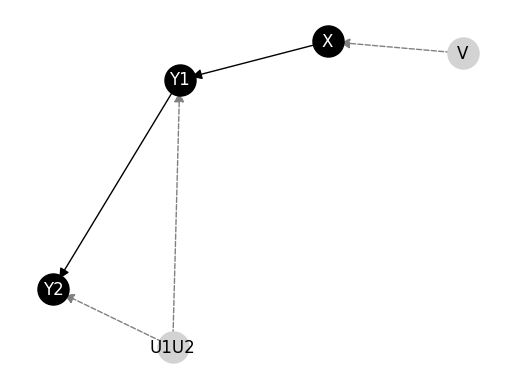

In [7]:
model.draw()

In [8]:
data = pd.read_csv(datapath, dtype='str')[model.endogenous]

In [9]:
data.head()

,X,Y1,Y2
0,1,1,1
1,1,1,0
2,1,1,0
3,1,1,1
4,1,1,0


## Counterfactual inference methods

First, load corresponding modules for using EMCC, precomputed EMCC, and tree-based EMCC; along with the package to make a causal query.

In [10]:
from bcause.inference.causal.multi import CausalMultiInference
from bcause.learning.parameter.expectation_maximization import ExpectationMaximization,ExpectationMaximizationPrecomputed,ExpectationMaximizationTrees

Set up the EMCC model with $N=20$ random initialization and $50$ iterations for the standard EMCC.
Then, run the causal query of probability of sufficiency of $Y1$ on $Y2$.

In [11]:
models = []
for i in range(20):
    randomUtil.seed(i)
    model.randomize_factors(model.exogenous, allow_zero=False,in_place=True,vtype="list")
    em = ExpectationMaximization(model, vtype="list")
    em.run(data,max_iter=50)
    models.append(em.model)
inf = CausalMultiInference(models)
inf.prob_sufficiency(cause="Y1", effect="Y2",true_false_cause=("1","0"), true_false_effect=("1","0"))

[0.043785350185889235, 0.7736933550463929]

Set up the EMCC model with $N=20$ random initialization and $50$ iterations for the precomputed EMCC. Then, run the causal query of probability of sufficiency of $Y1$ on $Y2$.

In [15]:
models = []
for i in range(20):
    randomUtil.seed(i)
    model.randomize_factors(model.exogenous, allow_zero=False,in_place=True, vtype="list")
    em = ExpectationMaximizationPrecomputed(model,as_list=True)
    em.run(data,max_iter=50)
    models.append(em.model)
inf = CausalMultiInference(models)
inf.prob_sufficiency(cause="Y1", effect="Y2",true_false_cause=("1","0"), true_false_effect=("1","0"))

[0.04378535018588922, 0.7736933550463929]

Set up the EMCC model with $N=20$ random initialization and $50$ iterations for the precomputed tree-based EMCC. Then, run the causal query of probability of sufficiency of $Y1$ on $Y2$.

In [15]:
models = []
for i in range(20):
    randomUtil.seed(i)
    em = ExpectationMaximizationTrees(model.randomize_factors(model.exogenous, allow_zero=False),ignore_convergence=True)
    em.run(data, max_iter=50)
    models.append(em.model)
inf = CausalMultiInference(models)
inf.prob_sufficiency(cause="Y1", effect="Y2",true_false_cause=("1","0"), true_false_effect=("1","0"))